In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


def ggplot_dataset(X, title="Conjunto de datos", h=None):
    df = pd.DataFrame(X, columns=["x", "y"])
    plt.figure()
    plt.hist2d(df["x"], df["y"], bins=100, cmap="viridis", cmin=1, alpha=0.7)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


def eyeglasses(center=(0, 0), r=1, separation=3, n=500, bridge_height=0.2):
    exclude_theta = np.arcsin(bridge_height / r)
    effective_angle = np.pi - exclude_theta

    c_x1 = center[0] - separation / 2
    c_x2 = center[0] + separation / 2
    c_y = center[1]

    tunnel_offset = r * np.cos(exclude_theta)
    tunnel_diameter = separation - 2 * tunnel_offset
    tunnel_length = 2 * np.pi / 2 * np.sqrt(tunnel_diameter**2 + bridge_height**2) / 2

    arc_length = 2 * effective_angle * r
    total_length = 2 * arc_length + 2 * tunnel_length

    n_tunnel = round(tunnel_length / total_length * n)
    n_arc = round(arc_length / total_length * n)
    n_reminder = n - 2 * n_tunnel - 2 * n_arc

    circle1 = arc(center=(c_x1, c_y), r=r, n=n_arc + n_reminder, max_abs_angle=effective_angle, angle_shift=np.pi)
    circle2 = arc(center=(c_x2, c_y), r=r, n=n_arc, max_abs_angle=effective_angle)

    tunnel_c_x = c_x1 + tunnel_offset + tunnel_diameter / 2
    top_tunnel = arc(center=(tunnel_c_x, c_y + bridge_height), r=(tunnel_diameter / 2, bridge_height / 2),
                     n=n_tunnel, max_abs_angle=np.pi / 2, angle_shift=np.pi / 2)
    bottom_tunnel = arc(center=(tunnel_c_x, c_y - bridge_height), r=(tunnel_diameter / 2, bridge_height / 2),
                        n=n_tunnel, max_abs_angle=np.pi / 2, angle_shift=-np.pi / 2)

    return np.vstack((circle1, circle2, top_tunnel, bottom_tunnel))


def arc(center=(0, 0), r=1, n=500, sampling="uniform", max_abs_angle=np.pi, angle_shift=0):
    if sampling == "uniform":
        theta = np.random.uniform(-max_abs_angle, max_abs_angle, n)
    elif sampling == "normal":
        angle_sd = max_abs_angle / 1.50
        theta = truncnorm.rvs(-max_abs_angle, max_abs_angle, loc=0, scale=angle_sd, size=n)
    else:
        raise ValueError("Sampling should be either 'uniform' or 'normal'")

    x = center[0] + r * np.cos(theta - angle_shift)
    y = center[1] + r * np.sin(theta - angle_shift)
    return np.column_stack((x, y))


def filled_circle(center=(0, 0), max_r=1, r_power=4, n=500):
    theta = np.random.uniform(-np.pi, np.pi, n)
    r = np.random.uniform(0, 1, n) ** (1 / r_power) * max_r
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    return np.column_stack((x, y))


def add_noise(X, sd=1):
    n, d = X.shape
    noise = np.random.normal(0, sd, (n, d))
    return X + noise


def add_outliers(X, frac=0.05, iqr_factor=1.5):
    n, d = X.shape
    amount = int(round(frac * n))
    qs = np.percentile(X, [25, 75], axis=0)
    iqr = qs[1] - qs[0]
    iqr_sign = np.random.choice([-1, 1], amount)
    ixs = np.random.choice(n, amount, replace=True)
    X[ixs, :] = X[ixs, :] + iqr_factor * iqr_sign[:, np.newaxis] * np.tile(iqr, (amount, 1))
    return X


def add_dummy_dimensions(X, d=1):
    n, _ = X.shape
    new_columns = np.random.normal(0, 1, (n, d))
    return np.hstack((X, new_columns))

# # Example usage
# X = eyeglasses(center=(0, 0), r=1, separation=3, n=2000, bridge_height=0.2)
# X = add_noise(X, sd=0.05)
# X = add_outliers(X, frac=0.05, iqr_factor=1.5)
# X = add_dummy_dimensions(X, d=1)
# ggplot_dataset(X)


In [31]:
X = arc( n=500)

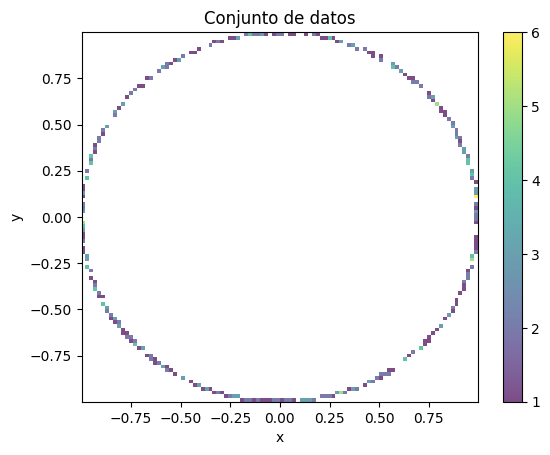

In [32]:
ggplot_dataset(X)

In [33]:
import gudhi as gd

In [34]:
dgm = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2).persistence()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

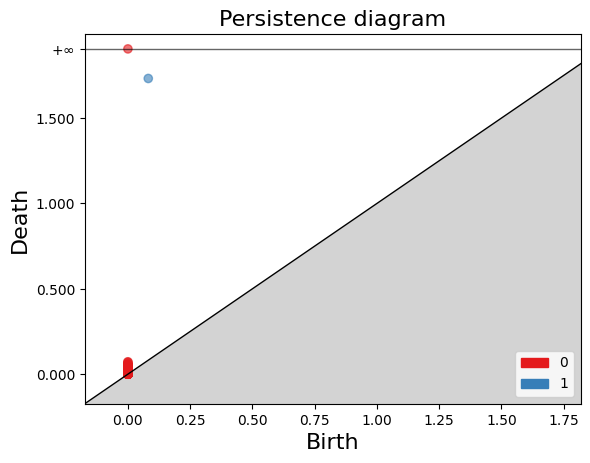

In [35]:
gd.plot_persistence_diagram(dgm)

In [52]:
import numpy as np
from sklearn.metrics import pairwise_distances
import networkx as nx

class FermatDistance:
    def __init__(self, sp, method):
        self.sp = sp
        self.method = method

def fermat_dist(X, method="full", alpha=2, landmarks_frac=0.1):
    available_methods = ["full", "knn", "landmarks"]
    if method not in available_methods:
        raise ValueError("Method is not available")
    
    n = X.shape[0]
    dist_matrix = pairwise_distances(X, metric="euclidean", squared=True) ** alpha
    
    if method == "knn":
        k = int(np.sqrt(n))
        for i in range(n):
            col_dists = dist_matrix[:, i]
            min_k_dist = np.partition(col_dists, k + 1)[k]
            remove_nodes = col_dists >= min_k_dist
            dist_matrix[remove_nodes, i] = 0
    
    g = nx.from_numpy_array(dist_matrix, create_using=nx.Graph)
    
    if method == "landmarks":
        landmarks_ids = np.random.choice(n, size=int(n * landmarks_frac), replace=False)
        landmarks_sp = dict(nx.single_source_dijkstra_path_length(g, source=None, cutoff=None, weight='weight'))
        sp = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                min_path = float("inf")
                for landmark in landmarks_ids:
                    path_length = landmarks_sp[landmark][i] + landmarks_sp[landmark][j]
                    if path_length < min_path:
                        min_path = path_length
                sp[i, j] = min_path
    
    else:
        sp = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
        sp = pd.DataFrame(sp)
        sp = sp.sort_index(axis=0).sort_index(axis=1).to_numpy()
    
    return FermatDistance(sp=sp, method=method)

# Example usage



In [93]:
n = 400
d = 2
X = arc(n=n)
fermat_distance = fermat_dist(X, method="full", alpha=2)

In [94]:
np.max(fermat_distance.sp)

0.0002353868027898839

In [95]:
dgm = gd.RipsComplex(
    distance_matrix=fermat_distance.sp
).create_simplex_tree(max_dimension=2).persistence()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

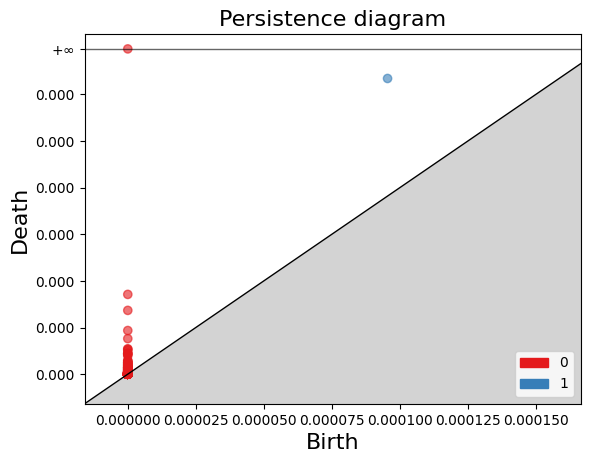

In [96]:
gd.plot_persistence_diagram(dgm)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

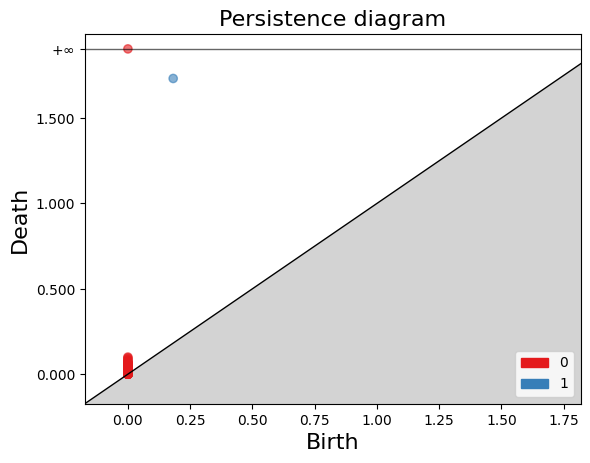

In [88]:
dgm = gd.RipsComplex(
    points=X
).create_simplex_tree(max_dimension=2).persistence()
gd.plot_persistence_diagram(dgm)